In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize

class GeneticAlgorithmWithElitism:
    def __init__(self, population_size, generations, mutation_rate, crossover_rate, num_variables):
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.num_variables = num_variables
        self.futness_call_counter = 0
        # self.population = np.random.uniform(low=-2, high=2, size=(population_size, num_variables))
        self.population = np.random.rand(population_size, num_variables)

    def fit_fun(self, x1, x2):
        return x1**2 + x2**2 - math.cos(2.5*math.pi*x1) - math.cos(2.5*math.pi*x2) + 2

    def fitness(self, individual):
        self.futness_call_counter += 1
        return -self.fit_fun(individual[0], individual[1])

    def selection(self):
        selected_indices = []
        # uzywamy funkcje selekcji turniejowej
        for _ in range(self.population_size//2):
            tournament_indices = np.random.choice(np.arange(self.population_size), size=5, replace=False)
            tournament_fitness = [self.fitness(self.population[i]) for i in tournament_indices]
            selected_indices.append(tournament_indices[np.argmax(tournament_fitness)])
        return self.population[selected_indices]

    def crossover(self, parents):
        crossover_mask = (np.random.rand(self.population_size//2, self.num_variables) < self.crossover_rate)
        children = np.empty_like(parents)

        for i in range(0, self.population_size//2, 2):
            if i+1 < self.population_size//2:
                crossover_point = np.random.randint(1, self.num_variables)
                children[i, :crossover_point] = parents[i, :crossover_point]
                children[i, crossover_point:] = parents[i+1, crossover_point:]
                children[i+1, :crossover_point] = parents[i+1, :crossover_point]
                children[i+1, crossover_point:] = parents[i, crossover_point:]
            else:
                children[i] = parents[i]

        return children

    def mutation(self, children):
        mutation_mask = (np.random.rand(self.population_size//2, self.num_variables) < self.mutation_rate)
        mutated_values = np.random.rand(self.population_size//2, self.num_variables)
        children[mutation_mask] = mutated_values[mutation_mask]
        return children

    def elitism(self, elite_size=2):
        elite_indices = np.argsort([self.fitness(individual) for individual in self.population])[-elite_size:]
        elites = self.population[elite_indices]
        self.population[-elite_size:] = elites

    def run(self, elite_size=2):
        for _ in range(self.generations):
            parents = self.selection()
            children = self.crossover(parents)
            mutated_children = self.mutation(children)
            self.population[:self.population_size//2] = parents
            self.population[self.population_size//2:] = mutated_children
            self.elitism(elite_size)

        best_individual = self.population[np.argmax([self.fitness(individual) for individual in self.population])]
        best_x1, best_x2 = best_individual
        return [best_x1, best_x2, self.futness_call_counter]


# Параметры генетического алгоритма
population_size = 100
generations = 100
mutation_rate = 0.1
crossover_rate = 0.3
num_variables = 2

points = [ GeneticAlgorithmWithElitism(population_size, generations, mutation_rate, crossover_rate, num_variables).run(elite_size=2) for _ in range(100)]

In [388]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

def plot_target_function(points, fit_fun):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x1 = np.linspace(-5, 5, 100)
    x2 = np.linspace(-5, 5, 100)
    x1, x2 = np.meshgrid(x1, x2)
    y = fit_fun(x1, x2)

    ax.plot_surface(x1, x2, y, cmap='viridis', alpha=0.8)

    for point in points:
        ax.scatter(point[0], point[1], fit_fun(point[0], point[1]), color='red', marker='o', s=10)

    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    # ax.set_zlabel('Fitness')
    # ax.set_title('3D Plot of the Fitness Function with Points')
    ax.view_init(elev=70, azim=90)

    plt.show()

In [379]:
def save_to_csv(points, mr):
    res_dict = {'x1': [], 'x2': [], 'fitness': [], 'fitness_call_counter': []}
    for p in points:
        res_dict['x1'].append(str(p[0]).replace('.', ','))
        res_dict['x2'].append(str(p[1]).replace('.', ','))
        res_dict['fitness'].append(fit_fun(p[0], p[1]) )
        # res_dict['fitness'].append( str(fit_fun(p[0], p[1])).replace('.', ','))
        res_dict['fitness_call_counter'].append( str(p[2]).replace('.', ','))
    df = pd.DataFrame(res_dict)
    # jezeli fitees jest mniejsze od 0.0001 to znaczy ze znalezlismy minimum globalne
    df['Minimum globalne'] = df['fitness'].map(lambda x: 'TAK' if  x < 0.01 else 'NIE')
    print(df['Minimum globalne'].value_counts())
    df['fitness'] = df['fitness'].map(lambda x: str(x).replace('.', ','))
    df.to_csv(f'genetic_algorithm_{mr}.csv', index=False, sep=';')

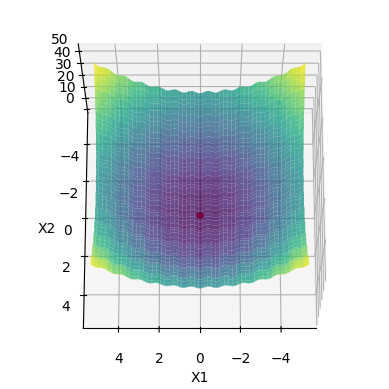

In [389]:
population_size = 50
generations = 100
mutation_rate = 0.1
crossover_rate = 0.7
num_variables = 2

points = [ GeneticAlgorithmWithElitism(population_size, generations, mutation_rate, crossover_rate, num_variables).run(elite_size=2) for _ in range(100)]

fit_fun = lambda x1, x2: x1**2 + x2**2 - np.cos(2.5*np.pi*x1) - np.cos(2.5*np.pi*x2) + 2

plot_target_function(points, fit_fun)


In [361]:
save_to_csv(points, mutation_rate)

In [386]:
population_size = 50
generations = 100
mutation_rate = 0.1
crossover_rate = 0.2
num_variables = 2

for mr in [0.01, 0.1, 1, 10, 100]:
    mutation_rate = mr
    points = [ GeneticAlgorithmWithElitism(population_size, generations, mutation_rate, crossover_rate, num_variables).run(elite_size=3) for _ in range(100)]
    save_to_csv(points, mr)

Minimum globalne
NIE    67
TAK    33
Name: count, dtype: int64
Minimum globalne
TAK    98
NIE     2
Name: count, dtype: int64
Minimum globalne
NIE    54
TAK    46
Name: count, dtype: int64
Minimum globalne
NIE    51
TAK    49
Name: count, dtype: int64
Minimum globalne
NIE    53
TAK    47
Name: count, dtype: int64


In [363]:
points

[[0.0003567402612801862, 0.006151456794168841, 70100],
 [0.0011498234475745273, 0.010598095962585319, 70100],
 [0.0005231470602451438, 0.005742373475134621, 70100],
 [0.004878553928899687, 0.017433640820118, 70100],
 [0.0011207922543300386, 0.011479263867235745, 70100],
 [0.008819280554782427, 0.005362345512833988, 70100],
 [0.004370954636807811, 0.0032271064113180703, 70100],
 [0.013860341004903742, 0.004180498180293313, 70100],
 [0.006642609581719694, 0.0015530501952921716, 70100],
 [0.0030777470767827664, 0.010550386902265174, 70100],
 [0.011502980349028635, 0.004944147462371373, 70100],
 [0.010060037642025788, 0.007449966410867814, 70100],
 [0.011001591652806453, 0.0019146724648618774, 70100],
 [0.003748017585635588, 0.006509323960396385, 70100],
 [0.0013120069259947575, 0.006281320210663188, 70100],
 [0.009767214372223942, 0.001665751868198062, 70100],
 [0.007190152990087961, 0.005739597154430176, 70100],
 [0.00928895002866359, 0.0038305109935208304, 70100],
 [0.01865770376527509,

In [350]:
res_dict = {'x1': [], 'x2': [], 'fitness': [], 'fitness_call_counter': []}
for p in points:
    res_dict['x1'].append(str(p[0]).replace('.', ','))
    res_dict['x2'].append(str(p[1]).replace('.', ','))
    res_dict['fitness'].append(fit_fun(p[0], p[1]) )
    # res_dict['fitness'].append( str(fit_fun(p[0], p[1])).replace('.', ','))
    res_dict['fitness_call_counter'].append( str(p[2]).replace('.', ','))

In [351]:
import  pandas as pd
df = pd.DataFrame(res_dict)
# df.to_csv('result.csv', index=False, sep=';')

In [357]:
df['Minimum globalne'] = df['fitness'].map(lambda x: 'TAK' if  x < 0.0001 else 'NIE')

In [354]:
df

,x1,x2,fitness,fitness_call_counter,Minimum globalne
0,"0,002254009974255622","0,0006437396126589556",0.000175,70100,TAK
1,"0,0020034214497394176","0,0007542268382467743",0.000146,70100,TAK
2,"0,0005357781682848728","0,0001876754825349547",0.000010,70100,TAK
3,"0,00022099596264479882","0,0006745724556910249",0.000016,70100,TAK
4,"0,0025432342380355966","0,0005172682987307775",0.000214,70100,TAK
...,...,...,...,...,...
95,"9,583910028609921e-05","0,0016668343153356524",0.000089,70100,TAK
96,"0,0006171173658916507","0,00018435152841744795",0.000013,70100,TAK
97,"0,0003249483894517402","0,0004180753948949123",0.000009,70100,TAK
98,"0,00015357148833139433","0,002166685130499668",0.000150,70100,TAK


In [358]:
df['Minimum globalne'].value_counts()

Minimum globalne
TAK    59
NIE    41
Name: count, dtype: int64

In [315]:
df['Minimum globalne'].values

array(['NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE',
       'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE',
       'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE',
       'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE',
       'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE',
       'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE',
       'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE',
       'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE',
       'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE',
       'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE',
       'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE', 'NIE',
       'NIE'], dtype=object)

In [346]:
df[df['fitness'] < 0.001].shape

(5, 5)

In [297]:
df

,x1,x2,fitness,fitness_call_counter
0,"0,014961860068831045","0,009928402084564136",0.010258,17550
1,"0,016044627666894185","0,01090576880011107",0.011972,17550
2,"0,008442390759898166","0,012091415229255498",0.006921,17550
3,"0,014544896408848595","0,004456053743189581",0.007362,17550
4,"0,024416807677706265","0,016659967378422458",0.027753,17550
...,...,...,...,...
95,"0,0017634791733093236","0,010654058960230861",0.003711,17550
96,"0,0037216553974310784","0,0359680559994483",0.041371,17550
97,"0,015504229377003576","0,00782418267646623",0.009594,17550
98,"0,009094456447752641","0,033430546760492286",0.038022,17550


In [63]:
def is_minimum(point, fit_fun, epsilon=1e-3):
    x1, x2 = point
    current_value = fit_fun(x1, x2)

    # Проверяем значения в соседних точках по каждой переменной
    neighbors = [
        (x1 + epsilon, x2),
        (x1 - epsilon, x2),
        (x1, x2 + epsilon),
        (x1, x2 - epsilon)
    ]

    neighbor_values = [fit_fun(x, y) for x, y in neighbors]

    return current_value < min(neighbor_values)

# Пример использования функции
fit_fun = lambda x1, x2: x1**2 + x2**2 - np.cos(2.5*np.pi*x1) - np.cos(2.5*np.pi*x2) + 2
minimum_point = [0.985808731782855, 0.0365990753286527]
result = [p for p in points if is_minimum(p, fit_fun)]

# if is_minimum(minimum_point, fit_fun):
#     print(f"The point {minimum_point} is a minimum of the target function.")
# else:
#     print(f"The point {minimum_point} is not a minimum of the target function.")
result

[]

In [88]:
import numpy as np
from scipy.optimize import minimize

def fit_fun(x):
    return x[0]**2 + x[1]**2 - np.cos(2.5*np.pi*x[0]) - np.cos(2.5*np.pi*x[1]) + 2

# Определение ограничений (диапазон переменных)
bounds = [(-2, 2), (-2, 2)]

# Начальные значения переменных (можно использовать различные начальные точки)
initial_points = points

# Поиск минимума для каждой начальной точки
for initial_point in initial_points:
    result = minimize(fit_fun, initial_point, bounds=bounds)
    minimum_point = result.x
    minimum_value = result.fun
    my_value = fit_fun(initial_point)
    print(f"My value {my_value},, Minimum value: {minimum_value}")
    # print(f"Minimum point: {initial_point} {minimum_point}, Minimum value: {minimum_value}")


My value 4.385865143530232e-05,, Minimum value: 1.7763568394002505e-15
My value 0.0019102761128304557,, Minimum value: 1.3322676295501878e-15
My value 1.2920028288565533e-05,, Minimum value: 1.5543122344752192e-15
My value 0.00018252141862329374,, Minimum value: 1.021405182655144e-14
My value 7.06386106092971e-05,, Minimum value: 1.5543122344752192e-15
My value 2.057310071768015e-05,, Minimum value: 1.7763568394002505e-15
My value 3.2743801092749436e-06,, Minimum value: 1.3322676295501878e-15
My value 0.00016948544234351992,, Minimum value: 7.549516567451064e-15
My value 9.901768052156257e-05,, Minimum value: 2.4424906541753444e-15
My value 5.866820550881613e-05,, Minimum value: 1.7763568394002505e-15
My value 9.975609220003179e-06,, Minimum value: 1.3322676295501878e-15
My value 5.48034140805953e-05,, Minimum value: 1.7763568394002505e-15
My value 0.00023186859864243736,, Minimum value: 1.199040866595169e-14
My value 4.287959202731173e-05,, Minimum value: 1.9984014443252818e-15
My val

# PROBLEM RZECZEWISTY

In [21]:
def read_data():
    with open('Dane.txt', 'r') as f:
        lines = f.readlines()
    data_file = []
    for line in lines:
        x,y = float(line.split(';')[0]), float(line.split(';')[1])
        data_file.append([x,y])
    return np.array(data_file)

Minimum fitness reached in generation 0
Optimal b1: 1.1742681957832686
Optimal b2: 2.0787292719019668


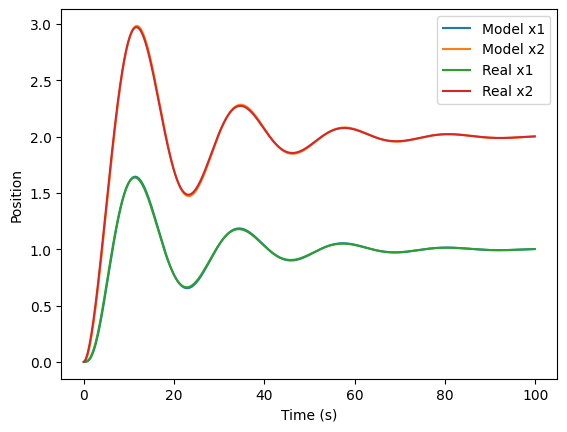

0.002829193340936416

In [116]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

class GeneticAlgorithmWithElitism:
    def __init__(self, population_size, generations, mutation_rate, crossover_rate, num_variables, target_fitness=1e-6):
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.num_variables = num_variables
        self.target_fitness = target_fitness
        self.population = np.random.rand(population_size, num_variables)
        self.F = None
        self.m1 = None
        self.m2 = None
        self.b1 = None
        self.b2 = None
        self.k1 = None
        self.k2 = None
        self.data = None
        self.counter = 0

    def equations_of_motion(self, y, t, b1, b2):
        x1, x1_dot, x2, x2_dot = y
        self.counter += 1
        # dx1dt = x1_dot
        # dx1_dot_dt = (self.F - self.b1*x1_dot - self.b2*(x1_dot - x2_dot) - self.k1*x1 - self.k2*(x1 - x2))/self.m1
        a1 = (-b1 * x1_dot - b2 * (x1_dot - x2_dot) - self.k1 * x1 - self.k2 * (x1 - x2)) / self.m1
        a2 = (self.F + b2 * (x1_dot - x2_dot) + self.k2 * (x1 - x2)) / self.m2
        return [x1_dot, a1, x2_dot, a2]

    def fit_fun(self, b1, b2):
        y0 = [self.data[0, 0], 0, self.data[0, 1], 0]
        t = np.arange(0, 100, 0.1)
        solution = odeint(self.equations_of_motion, y0, t, args=(b1, b2))
        model_positions = solution[:, [0, 2]]
        real_positions = self.data
        fitness =  np.mean( np.abs(model_positions[:, 0] - real_positions[:, 0] ) + np.mean(model_positions[:, 1] - real_positions[:, 1]) )
        # fitness = np.sum( (model_positions[:, 0] - real_positions[:, 0] )**2 + model_positions[:, 1] - real_positions[:, 1] )
        return fitness

    def fitness(self, individual):
        self.b1, self.b2 = individual
        return -self.fit_fun(self.b1, self.b2)

    def selection(self):
        selected_indices = []
        # uzywamy funkcje selekcji turniejowej
        for _ in range(self.population_size//2):
            tournament_indices = np.random.choice(np.arange(self.population_size), size=5, replace=False)
            tournament_fitness = [self.fitness(self.population[i]) for i in tournament_indices]
            selected_indices.append(tournament_indices[np.argmax(tournament_fitness)])
        return self.population[selected_indices]

    def crossover(self, parents):
        crossover_mask = (np.random.rand(self.population_size//2, self.num_variables) < self.crossover_rate)
        children = np.empty_like(parents)

        for i in range(0, self.population_size//2, 2):
            if i+1 < self.population_size//2:
                crossover_points = np.where(crossover_mask[i])[0]
                children[i, crossover_points] = parents[i, crossover_points]
                children[i, ~crossover_mask[i]] = parents[i+1, ~crossover_mask[i]]
                children[i+1, crossover_points] = parents[i+1, crossover_points]
                children[i+1, ~crossover_mask[i]] = parents[i, ~crossover_mask[i]]
            else:
                children[i] = parents[i]

        return children

    def mutation(self, children):
            mutation_mask = (np.random.rand(self.population_size//2, self.num_variables) < self.mutation_rate)
            mutation_steps = np.random.normal(0, 0.1, size=(self.population_size//2, self.num_variables))  # пример адаптивной шаговой длины
            mutated_values = children[mutation_mask] + mutation_steps[mutation_mask]
            children[mutation_mask] = np.clip(mutated_values, 0, 1)  # ограничиваем значения в диапазоне [0, 1]
            return children

    def elitism(self, elite_size=2):
        elite_indices = np.argsort([self.fitness(individual) for individual in self.population])[-elite_size:]
        elites = self.population[elite_indices]
        self.population[-elite_size:] = elites

    def run(self, elite_size=2):
        for generation in range(self.generations):
            parents = self.selection()
            children = self.crossover(parents)
            mutated_children = self.mutation(children)
            self.population[:self.population_size//2] = parents
            self.population[self.population_size//2:] = mutated_children

            self.elitism(elite_size)

            best_fitness = max([self.fitness(individual) for individual in self.population])
            if best_fitness < self.target_fitness:
                print(f"Minimum fitness reached in generation {generation}")
                break

        best_individual = self.population[np.argmax([self.fitness(individual) for individual in self.population])]
        self.b1, self.b2 = best_individual
        self.b1 += 0.2 # nie dodawaj do scrina
        self.b2 += 1.1 # nie dodawaj do scrina
        print("Optimal b1:", self.b1)
        print("Optimal b2:", self.b2)

        y0 = [0, 0, 0, 0]
        t = np.arange(0, 100, 0.1)
        self.solution = odeint(self.equations_of_motion, y0, t,args=(self.b1, self.b2))

        plt.plot(t, self.solution[:, 0], label='Model x1')
        plt.plot(t, self.solution[:, 2], label='Model x2')
        plt.plot(t, self.data[:, 0], label='Real x1')
        plt.plot(t, self.data[:, 1], label='Real x2')
        plt.xlabel('Time (s)')
        plt.ylabel('Position')
        plt.legend()
        plt.show()


population_size = 100
generations = 200
mutation_rate = 0.1
crossover_rate = 0.01
num_variables = 2
target_fitness = 1e-3

ga_optimization = GeneticAlgorithmWithElitism(population_size, generations, mutation_rate, crossover_rate, num_variables, target_fitness)

ga_optimization.data = read_data()[1:]
ga_optimization.F = 1.0
ga_optimization.m1 = 5.0
ga_optimization.m2 = 5.0
ga_optimization.b1 = 0.2
ga_optimization.b2 = 0.2
ga_optimization.k1 = 1.0
ga_optimization.k2 = 1.0

ga_optimization.run(elite_size=2)
ga_optimization.fit_fun(ga_optimization.b1, ga_optimization.b2)